<a href="https://colab.research.google.com/github/AnhVietPham/Deep-Learning/blob/main/DL-Pytorch/transfer-learning-example/transfer_learning_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = '/content/drive/MyDrive/Data-Kaggle/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor([1, 0, 0, 0])


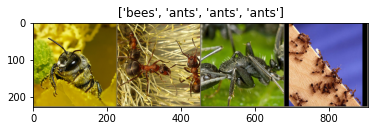

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicred: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5542 Acc: 0.6926
val Loss: 0.2220 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.3105 Acc: 0.8648
val Loss: 0.3142 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4450 Acc: 0.8320
val Loss: 0.2612 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3215 Acc: 0.8893
val Loss: 0.2568 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.2911 Acc: 0.9057
val Loss: 0.3183 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3230 Acc: 0.8852
val Loss: 0.2575 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.2403 Acc: 0.9221
val Loss: 0.2855 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3450 Acc: 0.8811
val Loss: 0.3045 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.3783 Acc: 0.8852
val Loss: 0.2458 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2864 Acc: 0.8730
val Loss: 0.2571 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.1928 Acc: 0.9098
val Loss: 0.2889 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2176 Acc: 0.9180
val Loss: 0.2230 Acc: 0.9150

Epoch 12/24
----------
t

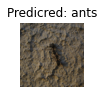

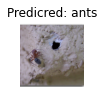

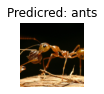

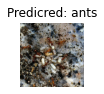

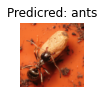

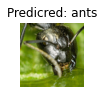

In [10]:
visualize_model(model_ft)

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6102 Acc: 0.7008
val Loss: 0.3371 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.4216 Acc: 0.8156
val Loss: 0.1849 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.3594 Acc: 0.8525
val Loss: 0.2249 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.3250 Acc: 0.8648
val Loss: 0.2267 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3876 Acc: 0.8197
val Loss: 0.2018 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.3822 Acc: 0.8320
val Loss: 0.2026 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2666 Acc: 0.8975
val Loss: 0.2463 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3189 Acc: 0.8607
val Loss: 0.2049 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2781 Acc: 0.8893
val Loss: 0.2322 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2926 Acc: 0.8852
val Loss: 0.1905 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3404 Acc: 0.8443
val Loss: 0.1888 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2956 Acc: 0.8730
val Loss: 0.2028 Acc: 0.9412

Ep

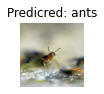

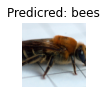

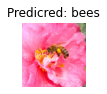

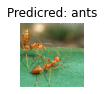

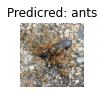

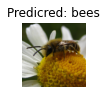

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()